In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import autograd
from autograd.numpy import cos,sin
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from new_data_builder import get_system

In [9]:
def get_hamiltonian(sys):
    
    if sys == 'pendulum':
        
        def hamiltonian_fn(coords):
            q, p = coords[:,0],coords[:,1]
            H = 9 * (1 - cos(q)) + p ** 2 / 2
            return H
    
    elif sys == 'mass_spring':
        def hamiltonian_fn(coords):
            q, p = coords[:,0],coords[:,1]
            H = q**2/2 + p ** 2/2
            return H
    
    elif sys == 'heinon':
        def hamiltonian_fn(coords):
            x, y, px, py = coords[:,0],coords[:,1],coords[:,2],coords[:,3]
            lambda_ = 1
            H = 0.5 * px ** 2 + 0.5 * py ** 2 + 0.5 * (x ** 2 + y ** 2) + lambda_ * (
                    (x ** 2) * y - (y ** 3) / 3)
            return H
    elif sys == 'nspring':
        def hamiltonian_fn(vecs, m=[1]*5, k=[1]*5, num_particles=5):
            energies = []
            for vec in vecs:
                num_particles = num_particles
                x = vec[:num_particles * 2]
                p = vec[2 * num_particles:]
                xs = x.reshape(-1, 2)
                ps = p.reshape(-1, 2)
                U1 = 0
                K = 0
                for i in range(num_particles):
                    for j in range(i + 1, num_particles):
                        U1 += .5 * k[i] * k[j] * ((xs[i] - xs[j]) ** 2).sum()
                    K += 0.5 * ((ps[i] ** 2).sum()) / m[i]
                energies.append(K+U1)
            return np.array(energies)
    elif sys == 'ngrav':
    
        def hamiltonian_fn(states):
            
            
            
            def potential_energy(state):

                tot_energy = np.zeros((1, 1, state.shape[2]))
                for i in range(state.shape[0]):
                    for j in range(i + 1, state.shape[0]):
                        r_ij = ((state[i:i + 1, 1:3] - state[j:j + 1, 1:3]) ** 2).sum(1, keepdims=True) ** .5
                        m_i = state[i:i + 1, 0:1]
                        m_j = state[j:j + 1, 0:1]
                tot_energy += m_i * m_j / r_ij
                U = -tot_energy.sum(0).squeeze()
                return U

            def kinetic_energy(state):

                energies = .5 * state[:, 0:1] * (state[:, 3:5] ** 2).sum(1, keepdims=True)
                T = energies.sum(0).squeeze()
                return T

            
            energies = []
            
            for state in states:
                qs=state[1:5].reshape(-1,2)
                ps=state[6:].reshape(-1,2)
                ms = np.array([1,1]).reshape(2,1)
                newstate = np.concatenate([ms,qs,ps],1).reshape(2,5,1)
                
                energies.append( potential_energy(newstate) + kinetic_energy(newstate))
    
            return np.array(energies)
    
    elif sys == 'three_body':
    
        def hamiltonian_fn(states):
            
            
            
            def potential_energy(state):
                '''U=\sum_i,j>i G m_i m_j / r_ij'''
                tot_energy = np.zeros((1, 1, state.shape[2]))
                for i in range(state.shape[0]):
                    for j in range(i + 1, state.shape[0]):
                        r_ij = ((state[i:i + 1, 1:3] - state[j:j + 1, 1:3]) ** 2).sum(1, keepdims=True) ** .5
                        m_i = state[i:i + 1, 0:1]
                        m_j = state[j:j + 1, 0:1]
                        tot_energy += m_i * m_j / r_ij
                U = -tot_energy.sum(0).squeeze()
                return U


            def kinetic_energy(state):
                '''T=\sum_i .5*m*v^2'''
                energies = .5 * state[:, 0:1] * (state[:, 3:5] ** 2).sum(1, keepdims=True)
                T = energies.sum(0).squeeze()
                return T


            def total_energy(state):
                return potential_energy(state) + kinetic_energy(state)

            
            energies = []
            
            for state in states:
                qs=state[:int(3*2)].reshape(-1,2)
                ps=state[int(3*2):].reshape(-1,2)
                ms = np.array([1,1,1]).reshape(3,1)
                newstate = np.concatenate([ms,qs,ps],1).reshape(3,5,1)
                
                energies.append( potential_energy(newstate) + kinetic_energy(newstate))
    
            return np.array(energies)
    
    
    elif sys == 'heinon':
        def hamiltonian_fn(coords):
            x, y, px, py = coords[:,0],coords[:,1],coords[:,2],coords[:,3]
            lambda_ = 1
            H = 0.5 * px ** 2 + 0.5 * py ** 2 + 0.5 * (x ** 2 + y ** 2) + lambda_ * (
                    (x ** 2) * y - (y ** 3) / 3)
            return H
    
    
    return hamiltonian_fn

In [29]:
NSAMPLES = 25
SYSTEMS = ['mass_spring','pendulum','ngrav','nspring']
nparts = [1,1,2,5,3,1]
INTEGRATORS = ['rk3','rk4','vi1','vi2','vi3','vi4']

Tmax = 20
dtvals = [0.01,0.05,0.1,0.2,0.3,0.4,0.5]
seed = 20

TABLE_VALUES = np.zeros((NSAMPLES,len(dtvals),len(SYSTEMS),len(INTEGRATORS),2))

for seed_val in range(NSAMPLES):
    for dt_index,dt in enumerate(dtvals):

        for sys_index,system in enumerate(SYSTEMS):
            gt = get_system(system,'gt',1,nparts[sys_index], Tmax, dt,dt,seed=seed_val)
            ham_fn = get_hamiltonian(system)
            for methdex,method in enumerate(INTEGRATORS):

                res = get_system(system,method,1,nparts[sys_index], Tmax, dt,dt,seed=seed_val)
                res = np.array(res)

                state_error= ((gt - res)**2).mean()
                energy_error= ((ham_fn(gt) - ham_fn(res))**2).mean()
    #             energy = hamiltonian_eval(res)
    #             energy_error = ((gt_energy-energy)**2)
                TABLE_VALUES[seed_val,dt_index,sys_index,methdex,0] = state_error
                TABLE_VALUES[seed_val,dt_index,sys_index,methdex,1] = energy_error

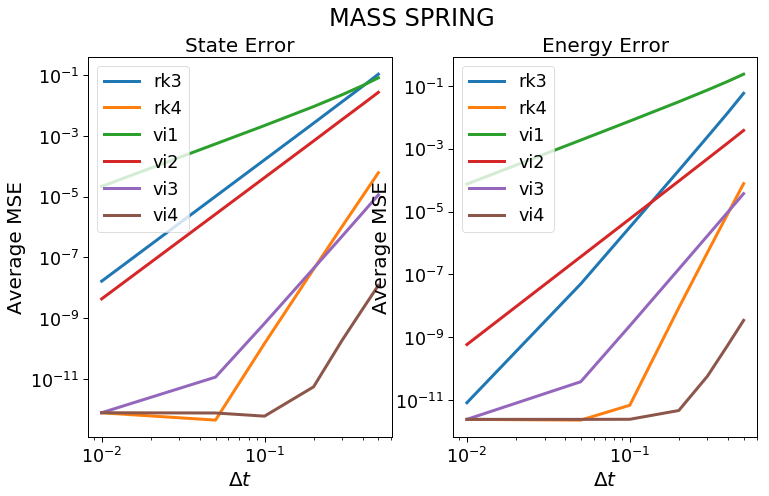

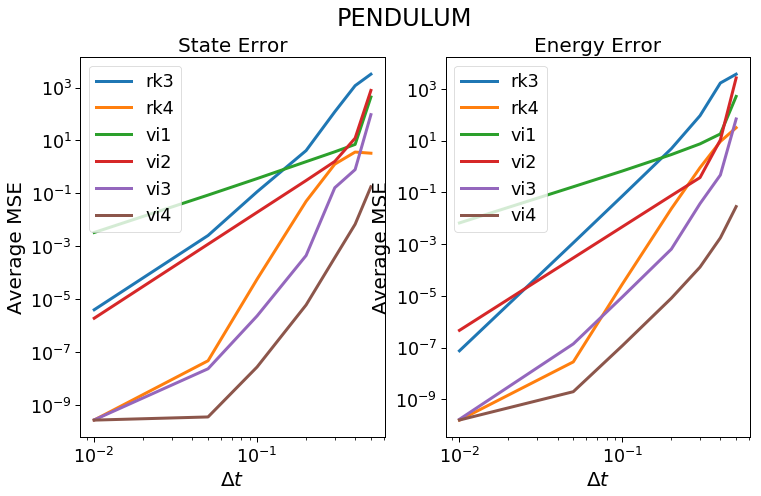

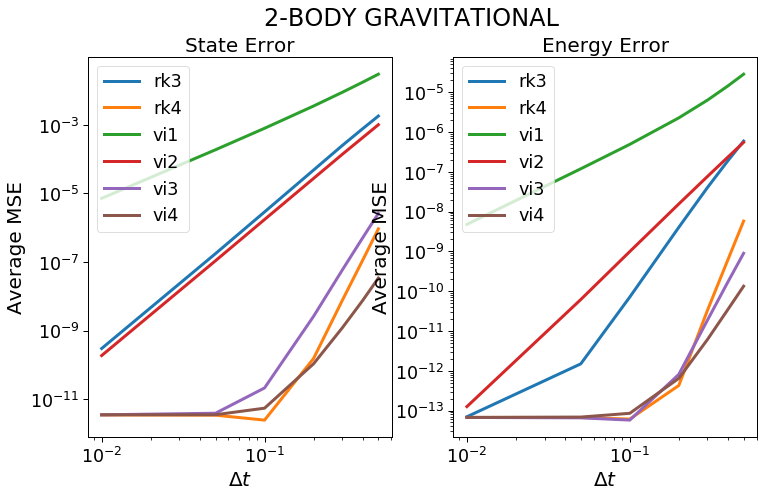

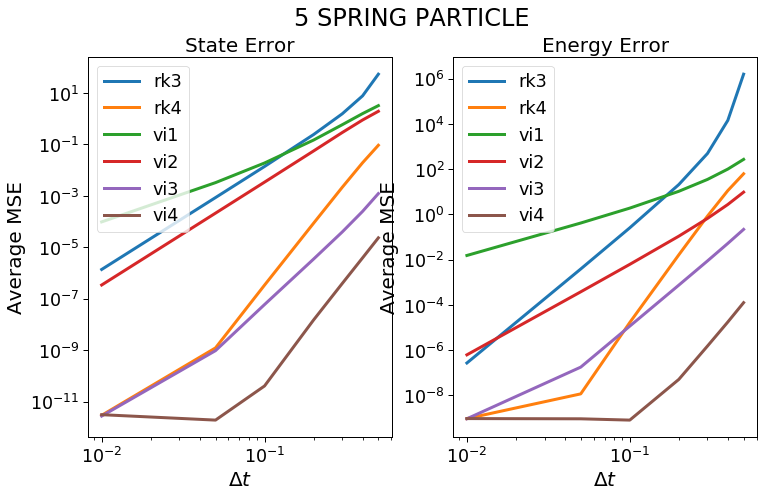

In [30]:
import seaborn as sns
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=2, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})


labels = ['MASS SPRING','PENDULUM','2-BODY GRAVITATIONAL','5 SPRING PARTICLE','3-BODY GRAVITATIONAL','HEINON HEILES']
for sysdex,sys in enumerate(SYSTEMS):
    
    fig,ax = plt.subplots(1,2,figsize=(12,7))
    axs = ax.ravel()
    fig.suptitle(labels[sysdex])
    for integ_index,integ in enumerate(INTEGRATORS):
        axs[0].plot(dtvals,TABLE_VALUES[:,:,sysdex,integ_index,0].mean(0),label=f'{integ}')
        axs[0+1].plot(dtvals,TABLE_VALUES[:,:,sysdex,integ_index,1].mean(0),label=f'{integ}')
    axs[0].set_title('State Error')
    axs[0+1].set_title('Energy Error')
    axs[0].set_ylabel('Average MSE')
    axs[0].set_xlabel(r'$\Delta t$')
    axs[1].set_ylabel('Average MSE')
    axs[1].set_xlabel(r'$\Delta t$')
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    
    axs[0].legend()
    axs[1].legend()
#     plt.tight_layout()
    plt.savefig(f'{sys}_{Tmax}.pdf',bbox_inches='tight')

In [6]:
NSAMPLES = 25
SYSTEMS = ['three_body','heinon']
nparts = [3,1]
INTEGRATORS = ['rk3','rk4','vi1','vi2','vi3','vi4']

Tmax = 20
dtvals = [0.01,0.05,0.1,0.5]
seed = 20

TABLE_VALUES = np.zeros((NSAMPLES,len(dtvals),len(SYSTEMS),len(INTEGRATORS),2))

for seed_val in range(NSAMPLES):
    for dt_index,dt in enumerate(dtvals):

        for sys_index,system in enumerate(SYSTEMS):
            gt = get_system(system,'gt',1,nparts[sys_index], Tmax, dt,dt,seed=seed_val)
            ham_fn = get_hamiltonian(system)
            for methdex,method in enumerate(INTEGRATORS):

                res = get_system(system,method,1,nparts[sys_index], Tmax, dt,dt,seed=seed_val)
                res = np.array(res)

                state_error= ((gt - res)**2).mean()
                energy_error= ((ham_fn(gt) - ham_fn(res))**2).mean()
    #             energy = hamiltonian_eval(res)
    #             energy_error = ((gt_energy-energy)**2)
                TABLE_VALUES[seed_val,dt_index,sys_index,methdex,0] = state_error
                TABLE_VALUES[seed_val,dt_index,sys_index,methdex,1] = energy_error

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:40: UserWarning: The following arguments have no effect for a chosen solver: `nbodies`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


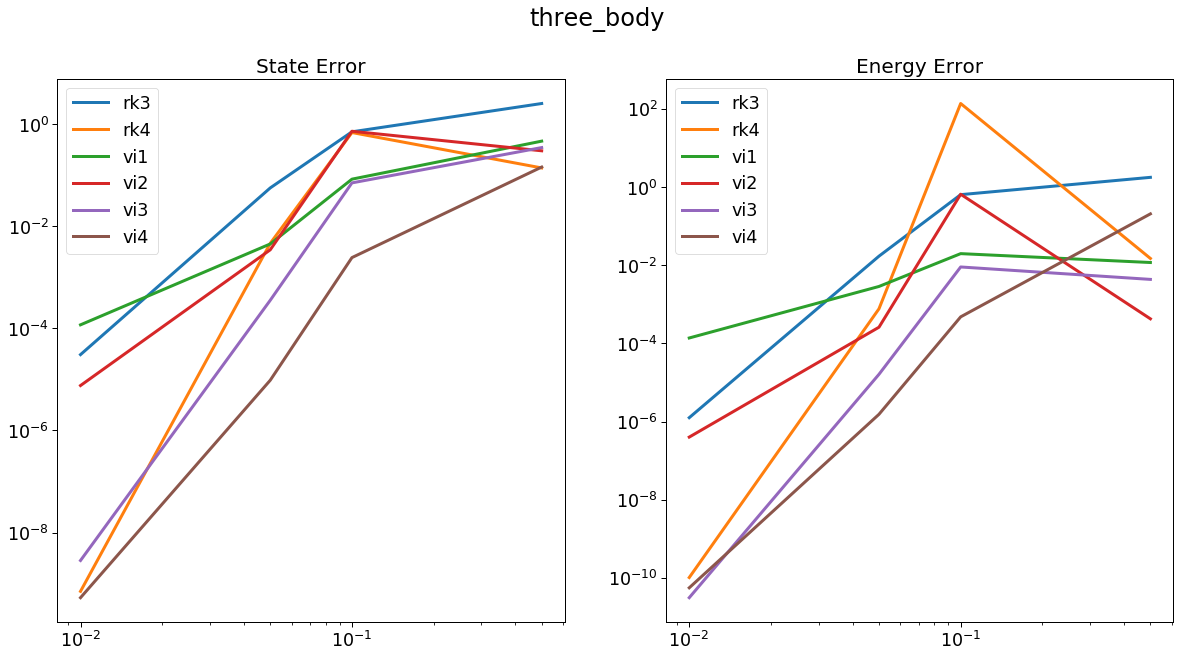

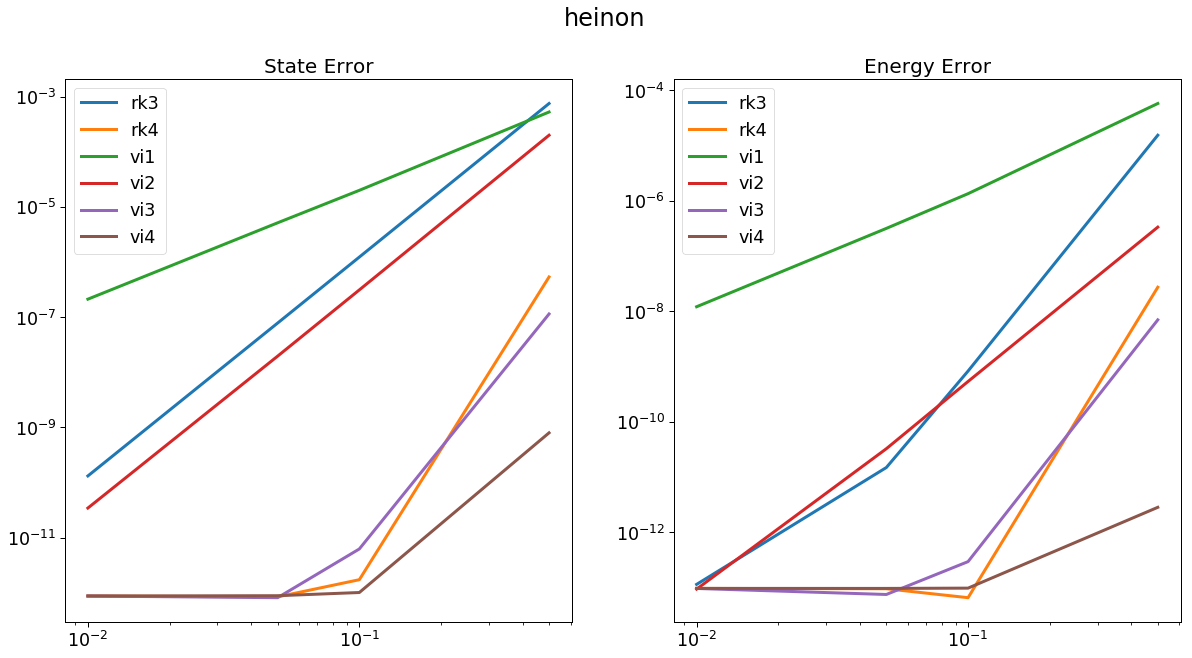

In [7]:
import seaborn as sns
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=2, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})

for sysdex,sys in enumerate(SYSTEMS):
    fig,axs = plt.subplots(1,2,figsize=(20,10))
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    fig.suptitle(sys)
    for integ_index,integ in enumerate(INTEGRATORS):
        axs[0].plot(dtvals,TABLE_VALUES[:,:,sysdex,integ_index,0].mean(0),label=f'{integ}')
        axs[1].plot(dtvals,TABLE_VALUES[:,:,sysdex,integ_index,1].mean(0),label=f'{integ}')
    axs[0].set_title('State Error')
    axs[1].set_title('Energy Error')
    axs[0].set_ylabel('Average MSE')
    axs[0].set_xlabel(r'$\Delta t$')
    axs[1].set_ylabel('Average MSE')
    axs[1].set_xlabel(r'$\Delta t$')
    
    axs[0].legend()
    axs[1].legend()
    
    plt.savefig(f'{sys}_{Tmax}.pdf',bbox_inches='tight')

In [ ]:
# fig,axs = plt.subplots(4,5,figsize=(20,20))
# ax = axs.ravel()
# methods_list = ['rk1','rk2','rk3','rk4','gt','vi1','vi2','vi3','vi4','gt']

# for methdex,method in enumerate(methods_list):
#     res = pendulum(method,1, Tmax, dt,dt,seed=seed)
#     if method !='gt':
#         res = np.array(res)

#     ax[methdex].scatter(res[:,0],res[:,1],label=method)
#     ax[methdex].set_title(method)
#     energy = hamiltonian_eval(res)
#     ax[methdex+10].scatter(np.arange(len(energy)),energy,label=method)
#     ax[methdex+10].set_title(f'{method}_energy')
# plt.legend()

In [ ]:
# fig,axs = plt.subplots(4,5,figsize=(20,20))
# ax = axs.ravel()
# methods_list = ['rk1','rk2','rk3','rk4','gt','vi1','vi2','vi3','vi4','gt']

# gt = pendulum('gt',1, Tmax, dt,dt,seed=seed)
# gt_energy = hamiltonian_eval(gt)
# for methdex,method in enumerate(methods_list):
#     res = pendulum(method,1, Tmax, dt,dt,seed=seed)
#     if method !='gt':
#         res = np.array(res)
#     state_error= ((gt - res)**2).mean(1)
#     ax[methdex].scatter(np.arange(len(state_error)),state_error,label=method)
    
#     energy = hamiltonian_eval(res)
#     energy_error = ((gt_energy-energy)**2)
#     ax[methdex+10].scatter(np.arange(len(energy_error)),energy_error,label=method)
# plt.legend()

In [79]:
##### ENERGY #####
def potential_energy(state):
    '''U=\sum_i,j>i G m_i m_j / r_ij'''
    tot_energy = np.zeros((1,1,state.shape[2]))
    for i in range(state.shape[0]):
        for j in range(i+1,state.shape[0]):
            r_ij = ((state[i:i+1,1:3] - state[j:j+1,1:3])**2).sum(1, keepdims=True)**.5
            m_i = state[i:i+1,0:1]
            m_j = state[j:j+1,0:1]
            tot_energy += m_i * m_j / r_ij
    U = -tot_energy.sum(0).squeeze()
    return U

def kinetic_energy(state):
    '''T=\sum_i .5*m*v^2'''
    energies = .5 * state[:,0:1] * (state[:,3:5]**2).sum(1, keepdims=True)
    T = energies.sum(0).squeeze()
    return T

def total_energy(state):
    return potential_energy(state) + kinetic_energy(state)

def update(t, state):

    qs = state[3:int(3+2*3)].reshape(-1, 2)
    ps = state[int(3+2*3):].reshape(-1, 2)
    ms = np.array([1, 1,1]).reshape(3, 1)
    state = np.concatenate([ms, qs, ps], 1)

    deriv = np.zeros_like(state)
    deriv[:, 1:3] = state[:, 3:5]  # dx, dy = vx, vy
    deriv[:, 3:5] = get_accelerations(state)

    qd = deriv[:, 1:3].ravel()
    pd = deriv[:, 3:5].ravel()
    return np.hstack([0,0,0, qd, pd])


##### DYNAMICS #####
def get_accelerations(state, epsilon=0):
    # shape of state is [bodies x properties]
    net_accs = [] # [nbodies x 2]
    for i in range(state.shape[0]): # number of bodies
        other_bodies = np.concatenate([state[:i, :], state[i+1:, :]], axis=0)
        displacements = other_bodies[:, 1:3] - state[i, 1:3] # indexes 1:3 -> pxs, pys
        distances = (displacements**2).sum(1, keepdims=True)**0.5
        masses = other_bodies[:, 0:1] # index 0 -> mass
        pointwise_accs = masses * displacements / (distances**3 + epsilon) # G=1
        net_acc = pointwise_accs.sum(0, keepdims=True)
        net_accs.append(net_acc)
    net_accs = np.concatenate(net_accs, axis=0)
    return net_accs
  

##### INITIALIZE THE TWO BODIES #####
def rotate2d(p, theta):
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s],[s, c]])
    return (R @ p.reshape(2,1)).squeeze()

def random_config(nu=2e-1, min_radius=0.9, max_radius=1.2):
    '''This is not principled at all yet'''
    state = np.zeros((3,5))
    state[:,0] = 1
    p1 = 2*np.random.rand(2) - 1
    r = np.random.rand() * (max_radius-min_radius) + min_radius

    p1 *= r/np.sqrt( np.sum((p1**2)) )
    p2 = rotate2d(p1, theta=2*np.pi/3)
    p3 = rotate2d(p2, theta=2*np.pi/3)

    # # velocity that yields a circular orbit
    v1 = rotate2d(p1, theta=np.pi/2)
    v1 = v1 / r**1.5
    v1 = v1 * np.sqrt(np.sin(np.pi/3)/(2*np.cos(np.pi/6)**2)) # scale factor to get circular trajectories
    v2 = rotate2d(v1, theta=2*np.pi/3)
    v3 = rotate2d(v2, theta=2*np.pi/3)

    # make the circular orbits slightly chaotic
    v1 *= 1 + nu*(2*np.random.rand(2) - 1)
    v2 *= 1 + nu*(2*np.random.rand(2) - 1)
    v3 *= 1 + nu*(2*np.random.rand(2) - 1)

    state[0,1:3], state[0,3:5] = p1, v1
    state[1,1:3], state[1,3:5] = p2, v2
    state[2,1:3], state[2,3:5] = p3, v3
    return state


##### INTEGRATE AN ORBIT OR TWO #####
def sample_orbits(timesteps=20, trials=5000, nbodies=3, orbit_noise=2e-1,
                  min_radius=0.9, max_radius=1.2, t_span=[0, 5], verbose=False, **kwargs):
    
    orbit_settings = locals()
    if verbose:
        print("Making a dataset of near-circular 3-body orbits:")
    
    

    state = random_config(nu=orbit_noise, min_radius=min_radius, max_radius=max_radius)
    orbit, settings = get_orbit(state, t_points=timesteps, t_span=t_span, nbodies=nbodies, **kwargs)
#         print(orbit.shape)
#         batch = orbit.transpose(2,0,1).reshape(-1,nbodies*5)

#         for state in batch:
#             dstate = update(None, state)
            
#             # reshape from [nbodies, state] where state=[m, qx, qy, px, py]
#             # to [canonical_coords] = [qx1, qx2, qy1, qy2, px1,px2,....]
#             coords = state.reshape(nbodies,5).T[1:].flatten()
#             dcoords = dstate.reshape(nbodies,5).T[1:].flatten()
#             x.append(coords)
#             dx.append(dcoords)

#             shaped_state = state.copy().reshape(nbodies,5,1)
#             e.append(total_energy(shaped_state))

#     data = {'coords': np.stack(x)[:N],
#             'dcoords': np.stack(dx)[:N],
#             'energy': np.stack(e)[:N] }
    return orbit
        


def get_orbit(state, update_fn=update, t_points=100, t_span=[0, 2],integrator_type='gt', **kwargs):
    if not 'rtol' in kwargs.keys():
        kwargs['rtol'] = 1e-12
        # kwargs['atol'] = 1e-12
        # kwargs['atol'] = 1e-9

    orbit_settings = locals()

    nbodies = state.shape[0]
    t_eval = np.arange(t_span[0], t_span[1], dt)
    if len(t_eval) != t_points:
        t_eval = t_eval[:-1]
    orbit_settings['t_eval'] = t_eval
    # print(state)

    qs = state[:, 1:3].ravel()
    ps = state[:, 3:5].ravel()

    if integrator_type == 'gt':
        path = solve_ivp(fun=update_fn, t_span=t_span, y0=np.hstack([1,1,1,qs, ps]),
                         t_eval=t_eval, method='DOP853', **kwargs)
        orbit = path['y'].T
    #         elif 'vi' in integrator_type:
    #             orbit = rk(dynamics_fn, np.arange(0, T_max, dt), state.flatten(), dt)
    else:
        orbit = rk(dynamics_fn, np.arange(0, T_max, dt), np.hstack([1,1,1, qs, ps]), dt)

    return orbit, orbit_settings




def dynamics_fn(state):
    return update(0, state)

def rk(dx_dt_fn, t, y0, dt):
    single_step = choose_integrator_nongraph(integrator_type)
    store = []
    store.append(y0)
    for i in range(len(t)):
        #             print(type(y0))
        ynext = single_step(dx_dt_fn, y0, dt)
        store.append(ynext)
        y0 = ynext

    return store[:-1]





##### LOAD OR SAVE THE DATASET #####
def get_dataset(experiment_name, save_dir, **kwargs):
    '''Returns an orbital dataset. Also constructs
    the dataset if no saved version is available.'''

    
    return sample_orbits(timesteps=int(np.ceil(Tmax / dt)), trials=1, nbodies=2, orbit_noise=5e-2,
                         min_radius=0.9, max_radius=1.2, t_span=[0, Tmax], verbose=False)



In [78]:
Tmax = 20
dt =0.01

In [80]:
res = get_dataset('hh','jj')

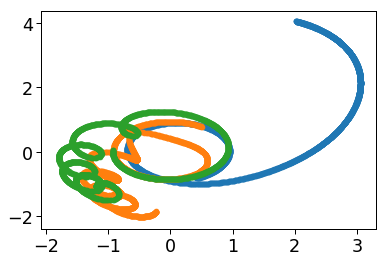

In [81]:
plt.figure()
plt.scatter(res[:,3],res[:,4])
plt.scatter(res[:,5],res[:,6])
plt.scatter(res[:,7],res[:,8])